In [1]:
# To display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import requests
import json
import time
from bech32 import bech32_encode, convertbits

from datetime import datetime
from tqdm import tqdm
from bech32 import bech32_decode, convertbits
from binascii import hexlify

In [3]:
pd.options.display.float_format = "{:.6f}".format

In [4]:
def bech32_to_hex(addr_bech32: str) -> str:
    hrp, data = bech32_decode(addr_bech32)
    if data is None:
        raise ValueError(f"Invalid bech32 address: {addr_bech32}")
    decoded = convertbits(data, 5, 8, False)
    return hexlify(bytes(decoded)).decode()

def safe_bech32_to_hex(addr):
    if pd.isna(addr):
        return None
    try:
        return bech32_to_hex(addr)
    except Exception:
        return None

def hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address."""
    data = bytes.fromhex(addr_hex)
    five_bit = convertbits(data, 8, 5)
    return bech32_encode(hrp, five_bit)


def safe_hex_to_bech32(addr_hex: str, hrp="addr") -> str:
    """Convert 128-char hex string to bech32 address with error handling."""
    try:
        data = bytes.fromhex(addr_hex)
        five_bit = convertbits(data, 8, 5)
        return bech32_encode(hrp, five_bit)
    except Exception as e:
        return None  

In [5]:
path = "/home/jovyan/work/New Topic/WRT_holders_df.csv"
WRT_holders_df = pd.read_csv(path)

In [6]:
WRT_holders_df.head()

,token,bech32_address,quantity,token_amount,hex_address
0,WRT,addr1wypr0np3xatwhddulsnj3aaac65qg768zgs2xpd2x...,18802768670327,18802768.670327,710237cc313756ebb5bcfc2728f7bdc6a8047b471220a3...
1,WRT,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,15889017227655,15889017.227655,11af97793b8702f381976cec83e303e9ce17781458c73c...
2,WRT,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,13797083749206,13797083.749206,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...
3,WRT,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,8805566666666,8805566.666666,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...
4,WRT,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,7560817668505,7560817.668505,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...


In [7]:
# Count how many bech32 addresses start with "addr1v"
enterprise_addr_count = WRT_holders_df["bech32_address"].str.startswith("addr1v").sum()
print(f"Number of Enterprise (addr1v...) addresses: {enterprise_addr_count}")

Number of Enterprise (addr1v...) addresses: 12


In [8]:
WRT_holders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9978 entries, 0 to 9977
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   token           9978 non-null   object 
 1   bech32_address  9978 non-null   object 
 2   quantity        9978 non-null   int64  
 3   token_amount    9978 non-null   float64
 4   hex_address     9955 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 389.9+ KB


# EDA-Token Amount Distribution

We conducted an initial exploration of token_amount across all 9,978 WRT token holders. The distribution is highly right-skewed, with the majority of users holding very small amounts and a small number of addresses holding disproportionately large balances.

As shown in the histogram (normal scale), most data points are concentrated near zero, and nearly invisible on the full scale due to extreme outliers. The log-scale histogram reveals a classic long-tail distribution, with a steep drop-off from small holders to a sparse set of large token holders.

Summary statistics reinforce this imbalance:

The median holding is just 10.9 tokens,

While the mean is 10,021, inflated by a maximum value of over 18 million.

The standard deviation exceeds 300,000, indicating extreme variance.


<Figure size 1200x500 with 0 Axes>

(array([9.956e+03, 6.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 3.76056353e+05, 7.52111707e+05, 1.12816706e+06,
        1.50422241e+06, 1.88027777e+06, 2.25633312e+06, 2.63238847e+06,
        3.00844383e+06, 3.38449918e+06, 3.76055453e+06, 4.13660989e+06,
        4.51266524e+06, 4.88872059e+06, 5.26477595e+06, 5.64083130e+06,
        6.01688665e+06, 6.39294201e+06, 6.76899736e+06, 7.14505271e+06,
        7.521108

Text(0.5, 1.0, 'Token Amount Distribution (Normal Scale)')

Text(0.5, 0, 'Token Amount')

Text(0, 0.5, 'Number of Holders')

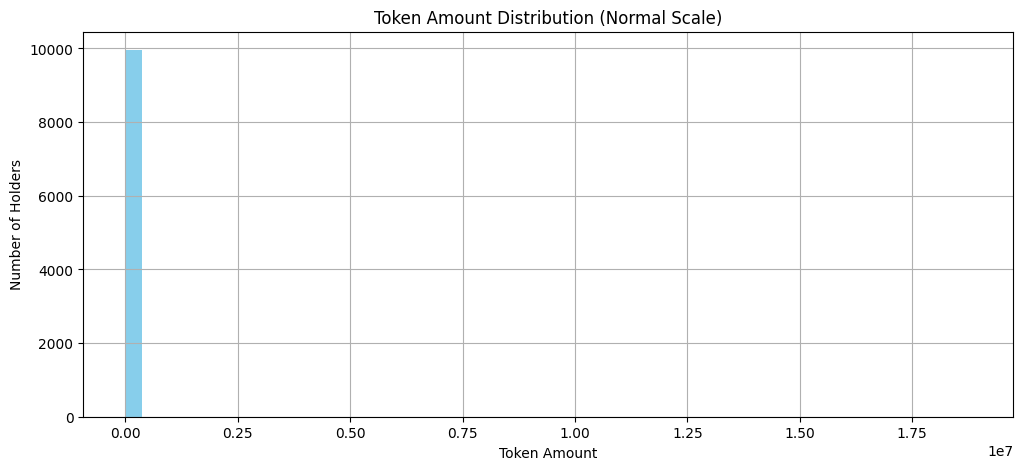

<Figure size 1200x500 with 0 Axes>

(array([2.17e+03, 6.42e+02, 5.46e+02, 6.88e+02, 6.18e+02, 5.23e+02,
        4.09e+02, 4.32e+02, 3.72e+02, 3.07e+02, 3.77e+02, 3.50e+02,
        3.24e+02, 2.83e+02, 2.36e+02, 2.07e+02, 1.79e+02, 1.52e+02,
        1.28e+02, 1.58e+02, 1.41e+02, 1.19e+02, 9.70e+01, 8.20e+01,
        8.30e+01, 5.50e+01, 6.70e+01, 4.60e+01, 2.90e+01, 3.70e+01,
        2.50e+01, 2.30e+01, 1.90e+01, 5.00e+00, 7.00e+00, 1.10e+01,
        7.00e+00, 3.00e+00, 3.00e+00, 2.00e+00, 4.00e+00, 3.00e+00,
        1.00e+00, 2.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 3.00e+00]),
 array([0.30103   , 0.44049383, 0.57995767, 0.71942151, 0.85888534,
        0.99834918, 1.13781302, 1.27727685, 1.41674069, 1.55620453,
        1.69566836, 1.8351322 , 1.97459603, 2.11405987, 2.25352371,
        2.39298754, 2.53245138, 2.67191522, 2.81137905, 2.95084289,
        3.09030673, 3.22977056, 3.3692344 , 3.50869824, 3.64816207,
        3.78762591, 3.92708975, 4.06655358, 4.20601742, 4.34548126,
        4.48494509

Text(0.5, 1.0, 'Token Amount Distribution (Log Scale)')

Text(0.5, 0, 'log10(Token Amount + 1)')

Text(0, 0.5, 'Number of Holders')

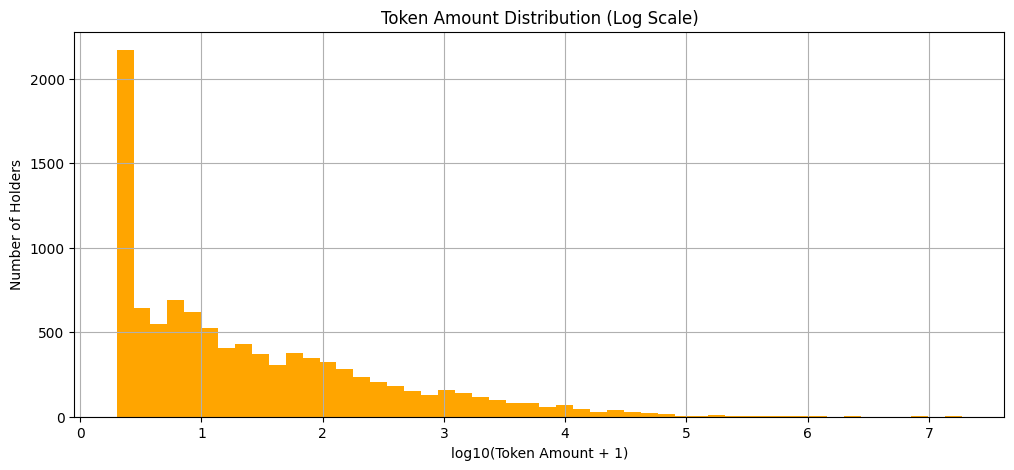

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Drop NaN and convert token_amount to float if needed
token_values = WRT_holders_df["token_amount"].dropna().astype(float)

# Plot normal scale histogram
plt.figure(figsize=(12, 5))
plt.hist(token_values, bins=50, color='skyblue')
plt.title("Token Amount Distribution (Normal Scale)")
plt.xlabel("Token Amount")
plt.ylabel("Number of Holders")
plt.grid(True)
plt.show()

# Plot log scale histogram
plt.figure(figsize=(12, 5))
plt.hist(np.log10(token_values + 1), bins=50, color='orange')  # +1 to avoid log(0)
plt.title("Token Amount Distribution (Log Scale)")
plt.xlabel("log10(Token Amount + 1)")
plt.ylabel("Number of Holders")
plt.grid(True)
plt.show()


In [93]:
print("Token Amount Summary Statistics:")
print(token_values.describe())


Token Amount Summary Statistics:
count       9978.000000
mean       10021.989200
std       312832.618641
min            1.000000
25%            2.000000
50%           10.912243
75%           96.979619
max     18802768.670327
Name: token_amount, dtype: float64


<Figure size 1000x400 with 0 Axes>

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: xlabel='token_amount'>

Text(0.5, 1.0, 'Boxplot of WRT Token Amounts')

Text(0.5, 0, 'token_amount')

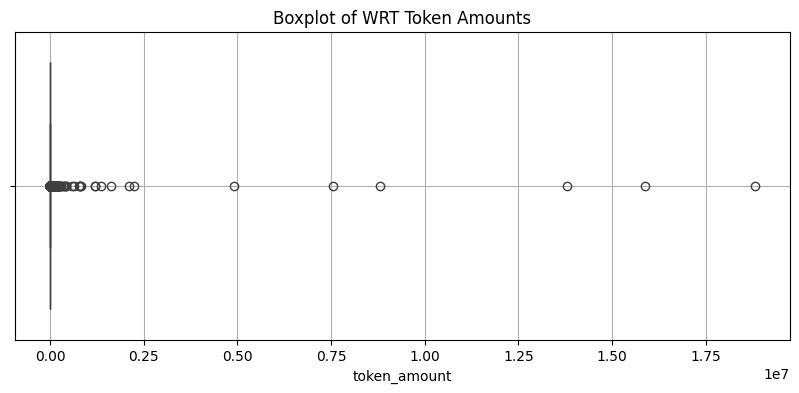

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(data=WRT_holders_df, x="token_amount")
plt.title("Boxplot of WRT Token Amounts")
plt.xlabel("token_amount")
plt.grid(True)
plt.show()


<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='token_amount', ylabel='Count'>

Text(0.5, 1.0, 'Log-Scaled Histogram of WRT Token Amounts')

Text(0.5, 0, 'token_amount')

Text(0, 0.5, 'Count (log scale)')

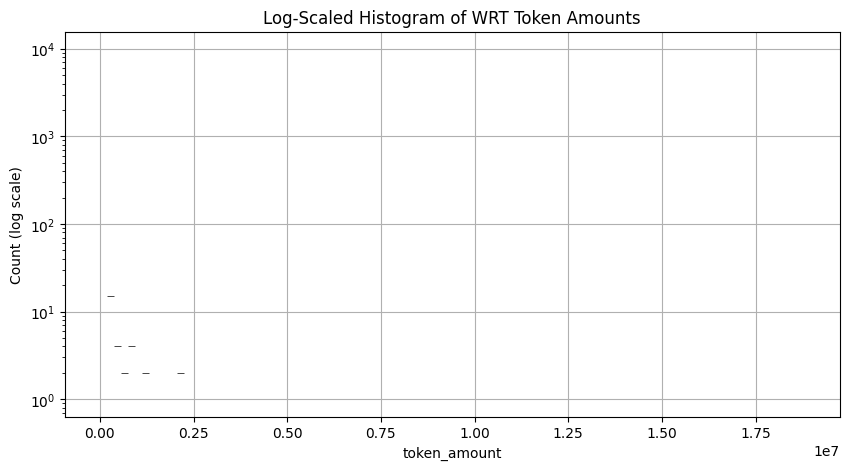

In [95]:
plt.figure(figsize=(10, 5))
sns.histplot(WRT_holders_df["token_amount"], bins=100, log_scale=(False, True))
plt.title("Log-Scaled Histogram of WRT Token Amounts")
plt.xlabel("token_amount")
plt.ylabel("Count (log scale)")
plt.grid(True)
plt.show()


# API Fetching Txs Summaries

In [14]:
def bech32_to_hex(bech32_addr):
    """
    Convert a bech32 Shelley address (e.g., addr1...) to hex.
    """
    hrp, data = bech32_decode(bech32_addr)
    if hrp is None or data is None:
        raise ValueError("Invalid bech32 address")
    decoded_bytes = bytes(convertbits(data, 5, 8, False))
    return decoded_bytes.hex()

def safe_bech32_to_hex(addr):
    try:
        return bech32_to_hex(addr)
    except Exception:
        return None

In [108]:
from collections import Counter

all_addresses = WRT_holders_df["bech32_address"].dropna().astype(str)

def classify_prefix(addr):
    if addr.startswith("DdzFF"):
        return "Byron (DdzFF)"
    elif addr.startswith("Ae2td"):
        return "Byron (Ae2td)"
    elif addr.startswith("addr1"):
        return "Shelley"
    elif addr.startswith("stake1"):
        return "Stake"
    else:
        return "Other / Unknown"

prefix_counts = Counter([classify_prefix(a) for a in all_addresses])
print(prefix_counts)


Counter({'Shelley': 9955, 'Byron (Ae2td)': 16, 'Byron (DdzFF)': 7})


In [ ]:
import requests
import json
import time
from tqdm.notebook import tqdm
from bech32 import bech32_decode, convertbits  # pip install bech32


def fetch_blockfrost_address_summaries(addresses, output_file="wrt_address_txs_summary.json",
                                       api_key="mainnetD5tXDiNzInPOA8ABiVQjb9gBJxB2zqXu",
                                       max_retries=3, sleep_time=0.2):
    headers = {"project_id": api_key}
    
    # ✅ Filter only valid bech32 addresses (exclude Byron)
    valid_addresses = [addr for addr in addresses if safe_bech32_to_hex(addr) is not None]

    summary = {}
    bar = tqdm(total=len(valid_addresses), desc="Fetching summaries")

    for addr in valid_addresses:
        for _ in range(max_retries):
            try:
                res = requests.get(f"https://cardano-mainnet.blockfrost.io/api/v0/addresses/{addr}/total", headers=headers)
                if res.status_code == 200:
                    summary[addr] = res.json()
                    break
            except Exception:
                pass
            time.sleep(sleep_time)
        bar.update(1)

    bar.close()

    successful_data = {k: v for k, v in summary.items() if "error" not in v}

    with open(output_file, "w") as f:
        json.dump(successful_data, f, indent=2)

    print(f"✅ Done! {len(successful_data)} results saved to '{output_file}'")

# 🟡 Replace with your real list
address_list = WRT_holders_df["bech32_address"].dropna().unique().tolist()
fetch_blockfrost_address_summaries(address_list)


Fetching summaries:   0%|          | 0/9955 [00:00<?, ?it/s]

In [107]:
valid_addresses = [addr for addr in address_list if safe_bech32_to_hex(addr) is not None]
dropped_addresses = set(address_list) - set(valid_addresses)
print(f"❌ Dropped {len(dropped_addresses)} invalid addresses")


❌ Dropped 23 invalid addresses


# Get Address Txs Summary

In [9]:
import json
import pandas as pd

# === Load JSON ===
with open("wrt_address_txs_summary.json") as f:
    data = json.load(f)

# === Token policy ID and decimals mapping ===
token_policies = {
    "GENS": "dda5fdb1002f7389b33e036b6afee82a8189becb6cba852e8b79b4fb0014df1047454e53",
    "MILK": "8a1cfae21368b8bebbbed9800fec304e95cce39a2a57dc35e2e3ebaa4d494c4b",
    "MIN": "29d222ce763455e3d7a09a665ce554f00ac89d2e99a1a83d267170c64d494e",
    "WRT": "c0ee29a85b13209423b10447d3c2e6a50641a15c57770e27cb9d507357696e67526964657273",
    "SUNDAE": "9a9693a9a37912a5097918f97918d15240c92ab729a0b7c4aa144d7753554e444145"
}

token_decimals = {
    "GENS": 6,
    "MILK": 0,
    "MIN": 6,
    "WRT": 6,
    "SUNDAE": 6
}

# === Extract records ===
# === Extract records ===
records = []

for addr, info in data.items():
    row = {"bech32_address": addr}

    # Transaction count
    row["tx_count"] = info.get("tx_count", 0)

    # Initialize cumulative values
    row["received_sum_ada"] = 0
    row["sent_sum_ada"] = 0
    for token in token_policies:
        row[f"received_sum_{token.lower()}"] = 0
        row[f"sent_sum_{token.lower()}"] = 0

    # Use sets to record unique token units (excluding lovelace)
    received_units = set()
    sent_units = set()

    # Parse received amounts
    for item in info.get("received_sum", []):
        unit = item["unit"]
        qty = int(item["quantity"])
        if unit == "lovelace":
            row["received_sum_ada"] += qty / 1_000_000
        else:
            received_units.add(unit)  # Track all unique tokens (no whitelist)
            for token, policy in token_policies.items():
                if unit.startswith(policy):
                    decimals = token_decimals[token]
                    row[f"received_sum_{token.lower()}"] += qty / (10 ** decimals)

    # Parse sent amounts
    for item in info.get("sent_sum", []):
        unit = item["unit"]
        qty = int(item["quantity"])
        if unit == "lovelace":
            row["sent_sum_ada"] += qty / 1_000_000
        else:
            sent_units.add(unit)  # Track all unique tokens (no whitelist)
            for token, policy in token_policies.items():
                if unit.startswith(policy):
                    decimals = token_decimals[token]
                    row[f"sent_sum_{token.lower()}"] += qty / (10 ** decimals)

    # Count unique tokens (excluding ADA/lovelace)
    row["received_token_count"] = len(received_units)
    row["sent_token_count"] = len(sent_units)

    records.append(row)


# === Convert to DataFrame
wrt_holders_txs_summary_df = pd.DataFrame(records)

# ✅ Done!
wrt_holders_txs_summary_df.head()


,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,received_sum_wrt,sent_sum_wrt,received_sum_sundae,sent_sum_sundae,received_token_count,sent_token_count
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42779232925.738472,42763334914.664612,0.000000,0.000000,3,3
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116743987.551725,102946903.802519,0.000000,0.000000,1,1
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8805566.666666,0.000000,0.000000,0.000000,2,0
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,539527077.049635,531966259.381130,0.000000,0.000000,12,6
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,768068915.976427,763163074.563795,0.000000,0.000000,9,9


In [10]:
wrt_holders_txs_summary_df["hex_address"] = wrt_holders_txs_summary_df["bech32_address"].apply(safe_bech32_to_hex)

# ✅ Done!
wrt_holders_txs_summary_df.head()

,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,received_sum_wrt,sent_sum_wrt,received_sum_sundae,sent_sum_sundae,received_token_count,sent_token_count,hex_address
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42779232925.738472,42763334914.664612,0.000000,0.000000,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116743987.551725,102946903.802519,0.000000,0.000000,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8805566.666666,0.000000,0.000000,0.000000,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,539527077.049635,531966259.381130,0.000000,0.000000,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,768068915.976427,763163074.563795,0.000000,0.000000,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...


In [11]:
wrt_holders_txs_summary_df['hex_address'][0]

'11af97793b8702f381976cec83e303e9ce17781458c73c4bb16fe02b831ffbacc6c0d1ac76e1562d400a8e991eede2210c691fb433009171b0'

In [12]:
wrt_holders_txs_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9947 entries, 0 to 9946
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bech32_address        9947 non-null   object 
 1   tx_count              9947 non-null   int64  
 2   received_sum_ada      9947 non-null   float64
 3   sent_sum_ada          9947 non-null   float64
 4   received_sum_gens     9947 non-null   float64
 5   sent_sum_gens         9947 non-null   float64
 6   received_sum_milk     9947 non-null   float64
 7   sent_sum_milk         9947 non-null   float64
 8   received_sum_min      9947 non-null   float64
 9   sent_sum_min          9947 non-null   float64
 10  received_sum_wrt      9947 non-null   float64
 11  sent_sum_wrt          9947 non-null   float64
 12  received_sum_sundae   9947 non-null   float64
 13  sent_sum_sundae       9947 non-null   float64
 14  received_token_count  9947 non-null   int64  
 15  sent_token_count     

In [13]:
wrt_holders_txs_summary_df['hex_address'].nunique()

9947

# Get Address Assets Summary

In [104]:
# Your API key
CARDANOSCAN_API_KEY = "520c718b-75dc-4898-aeca-199e059de866"

In [22]:
import requests
import json
import time
from tqdm.notebook import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# === Setup session with retry and backoff ===
session = requests.Session()
retries = Retry(
    total=5,
    backoff_factor=0.3,
    status_forcelist=[500, 502, 503, 504],
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retries)
session.mount("https://", adapter)

# === API ===
CARDANOSCAN_API_KEY = "520c718b-75dc-4898-aeca-199e059de866"
HEADERS = {"apiKey": CARDANOSCAN_API_KEY}
BASE_URL = "https://api.cardanoscan.io/api/v1/asset/list/byAddress"

# === Addresses ===
hex_addresses = wrt_holders_txs_summary_df["hex_address"].dropna().unique().tolist()
address_assets = {}

print(f"🔍 Fetching asset lists for {len(hex_addresses)} addresses...")

for addr in tqdm(hex_addresses, desc="Fetching assets by address"):
    all_assets = []
    page = 1

    while True:
        url = f"{BASE_URL}?address={addr}&pageNo={page}"
        try:
            response = session.get(url, headers=HEADERS, timeout=15)

            if response.status_code == 200:
                try:
                    data = response.json()
                    tokens = data.get("tokens", [])
                except json.JSONDecodeError:
                    print(f"⚠️ JSON decode error for {addr} page {page}")
                    break

                if not tokens:
                    break  # ✅ No more tokens

                all_assets.extend(tokens)
                page += 1
                time.sleep(0.25)

            else:
                print(f"❌ Failed for {addr} | Status: {response.status_code} | Body: {response.text}")
                break

        except requests.exceptions.SSLError as e:
            print(f"🔒 SSL error for {addr} page {page}: {e}")
            break

        except requests.exceptions.RequestException as e:
            print(f"⚠️ Request exception for {addr}: {e}")
            break

    address_assets[addr] = all_assets

# === Save
with open("wrt_address_assets_by_hex.json", "w") as f:
    json.dump(address_assets, f, indent=2)

print("✅ Done! Saved all asset results to 'wrt_address_assets_by_hex.json'")


🔍 Fetching asset lists for 9947 addresses...


Fetching assets by address:   0%|          | 0/9947 [00:00<?, ?it/s]

✅ Done! Saved all asset results to 'wrt_address_assets_by_hex.json'


In [14]:
import json
import pandas as pd

# === Load JSON ===
with open("wrt_address_assets_by_hex.json", "r") as f:
    address_assets = json.load(f)

# === Asset ID mapping ===
asset_id_map = {
    "dda5fdb1002f7389b33e036b6afee82a8189becb6cba852e8b79b4fb0014df1047454e53": "GENS",
    "8a1cfae21368b8bebbbed9800fec304e95cce39a2a57dc35e2e3ebaa4d494c4b": "MILK",
    "29d222ce763455e3d7a09a665ce554f00ac89d2e99a1a83d267170c64d494e": "MIN",
    "c0ee29a85b13209423b10447d3c2e6a50641a15c57770e27cb9d507357696e67526964657273": "WRT",
    "9a9693a9a37912a5097918f97918d15240c92ab729a0b7c4aa144d7753554e444145": "SUNDAE"
}

# === Token Decimals ===
token_decimals = {
    "WRT": 6,
    "SUNDAE": 6,
    "MILK": 0,
    "MIN": 6,
    "GENS": 6,
}

# === Container for each row ===
records = []

# === Parse each address ===
for hex_address, tokens in address_assets.items():
    token_counts = len(tokens)
    balances = {
        "gens_balance": 0,
        "milk_balance": 0,
        "min_balance": 0,
        "wrt_balance": 0,
        "sundae_balance": 0,
    }

    for token in tokens:
        asset_id = token.get("assetId")
        balance_raw = int(token.get("balance", 0))
        label = asset_id_map.get(asset_id)

        if label:  # If this is one of the 5 tracked tokens
            decimals = token_decimals[label]
            readable_balance = balance_raw / (10 ** decimals)
            balances[f"{label.lower()}_balance"] = readable_balance

    record = {
        "hex_address": hex_address,
        **balances,
        "token_num": token_counts
    }
    records.append(record)

# === Convert to DataFrame ===
wrt_holders_assets_summary_df = pd.DataFrame(records)

# === Preview result ===
wrt_holders_assets_summary_df.head()


,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num
0,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3
1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1
2,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2
3,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12
4,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1


In [15]:
wrt_holders_assets_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9947 entries, 0 to 9946
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hex_address     9947 non-null   object 
 1   gens_balance    9947 non-null   float64
 2   milk_balance    9947 non-null   float64
 3   min_balance     9947 non-null   float64
 4   wrt_balance     9947 non-null   float64
 5   sundae_balance  9947 non-null   float64
 6   token_num       9947 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 544.1+ KB


In [16]:
# === Merge the two dataframes on 'hex_address' ===
wrt_holders_txs_and_assets_summary_df = pd.merge(
    wrt_holders_txs_summary_df,
    wrt_holders_assets_summary_df,
    on="hex_address",
    how="left" 
)

wrt_holders_txs_and_assets_summary_df.head()


,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,sent_sum_sundae,received_token_count,sent_token_count,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1


In [17]:
wrt_holders_txs_and_assets_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9947 entries, 0 to 9946
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bech32_address        9947 non-null   object 
 1   tx_count              9947 non-null   int64  
 2   received_sum_ada      9947 non-null   float64
 3   sent_sum_ada          9947 non-null   float64
 4   received_sum_gens     9947 non-null   float64
 5   sent_sum_gens         9947 non-null   float64
 6   received_sum_milk     9947 non-null   float64
 7   sent_sum_milk         9947 non-null   float64
 8   received_sum_min      9947 non-null   float64
 9   sent_sum_min          9947 non-null   float64
 10  received_sum_wrt      9947 non-null   float64
 11  sent_sum_wrt          9947 non-null   float64
 12  received_sum_sundae   9947 non-null   float64
 13  sent_sum_sundae       9947 non-null   float64
 14  received_token_count  9947 non-null   int64  
 15  sent_token_count     

In [18]:
wrt_holders_txs_and_assets_summary_df['hex_address'][0]

'11af97793b8702f381976cec83e303e9ce17781458c73c4bb16fe02b831ffbacc6c0d1ac76e1562d400a8e991eede2210c691fb433009171b0'

# Get ADA Balance

In [33]:
!curl \
 --request GET 'https://api.cardanoscan.io/api/v1/address/balance?address=11af97793b8702f381976cec83e303e9ce17781458c73c4bb16fe02b831ffbacc6c0d1ac76e1562d400a8e991eede2210c691fb433009171b0' \
 --header "apiKey: 520c718b-75dc-4898-aeca-199e059de866"

{"hash":"11af97793b8702f381976cec83e303e9ce17781458c73c4bb16fe02b831ffbacc6c0d1ac76e1562d400a8e991eede2210c691fb433009171b0","balance":"355231554617"}

In [34]:
import requests
import time
import json
from tqdm import tqdm

# === Setup ===
API_KEY = "520c718b-75dc-4898-aeca-199e059de866"  
HEADERS = {"apiKey": API_KEY}
BASE_URL = "https://api.cardanoscan.io/api/v1/address/balance"

# === Get all unique hex addresses ===
hex_addresses = wrt_holders_txs_and_assets_summary_df["hex_address"].dropna().unique().tolist()

# === Container for results ===
ada_balance_dict = {}

# === Fetch ADA balance for each address ===
print(f"🔍 Fetching ADA balance for {len(hex_addresses)} addresses...")

for addr in tqdm(hex_addresses):
    for attempt in range(3):  # retry up to 3 times
        try:
            response = requests.get(f"{BASE_URL}?address={addr}", headers=HEADERS)
            if response.status_code == 200:
                data = response.json()
                balance = int(data.get("balance", 0))
                ada_balance_dict[addr] = balance
                break
            else:
                print(f"⚠️ {addr} | Status: {response.status_code}")
                time.sleep(1)
        except Exception as e:
            print(f"❌ {addr} | Error: {e}")
            time.sleep(1)
    time.sleep(0.2)  # rate limiting

# === Save as JSON file ===
with open("wrt_address_ada_balance.json", "w") as f:
    json.dump(ada_balance_dict, f, indent=2)

print("✅ Saved ADA balances to wrt_address_ada_balance.json")


🔍 Fetching ADA balance for 9947 addresses...


  7%|██▋                                   | 695/9947 [07:44<1:09:43,  2.21it/s]

❌ 011b48b573e4389db9a7eaaf09f5d2cd5c10b7abbadf3285118a68a6bc403915bc968937a6f72b7ac6b1db55507f82287af945a90b1dcab026 | Error: HTTPSConnectionPool(host='api.cardanoscan.io', port=443): Max retries exceeded with url: /api/v1/address/balance?address=011b48b573e4389db9a7eaaf09f5d2cd5c10b7abbadf3285118a68a6bc403915bc968937a6f72b7ac6b1db55507f82287af945a90b1dcab026 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))


100%|█████████████████████████████████████| 9947/9947 [2:13:50<00:00,  1.24it/s]


✅ Saved ADA balances to wrt_address_ada_balance.json


In [19]:
import json

# Step 1: Load ADA balances from JSON
with open("wrt_address_ada_balance.json", "r") as f:
    ada_balance_dict = json.load(f)

# Step 2: Map and convert to ADA in one step
wrt_holders_txs_and_assets_summary_df["ada_balance"] = (
    wrt_holders_txs_and_assets_summary_df["hex_address"].map(ada_balance_dict) / 1_000_000
)

# Optional: Check result
wrt_holders_txs_and_assets_summary_df.head()


,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3,355231.554617
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1,548.111950
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2,1010.909314
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12,361.709792
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1,1684.478544


In [20]:
wrt_holders_txs_and_assets_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9947 entries, 0 to 9946
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bech32_address        9947 non-null   object 
 1   tx_count              9947 non-null   int64  
 2   received_sum_ada      9947 non-null   float64
 3   sent_sum_ada          9947 non-null   float64
 4   received_sum_gens     9947 non-null   float64
 5   sent_sum_gens         9947 non-null   float64
 6   received_sum_milk     9947 non-null   float64
 7   sent_sum_milk         9947 non-null   float64
 8   received_sum_min      9947 non-null   float64
 9   sent_sum_min          9947 non-null   float64
 10  received_sum_wrt      9947 non-null   float64
 11  sent_sum_wrt          9947 non-null   float64
 12  received_sum_sundae   9947 non-null   float64
 13  sent_sum_sundae       9947 non-null   float64
 14  received_token_count  9947 non-null   int64  
 15  sent_token_count     

In [21]:
wrt_holders_txs_and_assets_summary_df.head()

,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3,355231.554617
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1,548.111950
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2,1010.909314
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12,361.709792
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1,1684.478544


# Save Final DF：

In [22]:
wrt_holders_txs_and_assets_summary_df.to_csv("wrt_holders_txs_and_assets_summary_df.csv", index=False)

# Get stake address:

In [23]:
path = "/home/jovyan/work/New Topic/wrt_holders_txs_and_assets_summary_df.csv"
wrt_holders_txs_and_assets_summary_df = pd.read_csv(path)
wrt_holders_txs_and_assets_summary_df.head()

,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3,355231.554617
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1,548.111950
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2,1010.909314
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12,361.709792
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1,1684.478544


In [24]:
wrt_holders_txs_and_assets_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9947 entries, 0 to 9946
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bech32_address        9947 non-null   object 
 1   tx_count              9947 non-null   int64  
 2   received_sum_ada      9947 non-null   float64
 3   sent_sum_ada          9947 non-null   float64
 4   received_sum_gens     9947 non-null   float64
 5   sent_sum_gens         9947 non-null   float64
 6   received_sum_milk     9947 non-null   float64
 7   sent_sum_milk         9947 non-null   float64
 8   received_sum_min      9947 non-null   float64
 9   sent_sum_min          9947 non-null   float64
 10  received_sum_wrt      9947 non-null   float64
 11  sent_sum_wrt          9947 non-null   float64
 12  received_sum_sundae   9947 non-null   float64
 13  sent_sum_sundae       9947 non-null   float64
 14  received_token_count  9947 non-null   int64  
 15  sent_token_count     

In [18]:
import requests
import json
import time
from tqdm.notebook import tqdm  

# === API config ===
API_KEY = "mainnetD5tXDiNzInPOA8ABiVQjb9gBJxB2zqXu"
HEADERS = {"project_id": API_KEY}
BASE_URL = "https://cardano-mainnet.blockfrost.io/api/v0/addresses"

# === Load addresses ===
bech32_addresses = wrt_holders_txs_and_assets_summary_df["bech32_address"].dropna().unique().tolist()

# === Container for results ===
addr_to_stake = {}

# === Loop and call API with tqdm progress bar ===
for addr in tqdm(bech32_addresses, desc="🔍 Fetching stake addresses"):
    url = f"{BASE_URL}/{addr}/extended"
    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            data = response.json()
            stake_address = data.get("stake_address")
            addr_to_stake[addr] = stake_address
        else:
            addr_to_stake[addr] = None
    except Exception as e:
        addr_to_stake[addr] = None
    time.sleep(0.3)

# === Save to JSON ===
with open("wrt_holders_stake_address.json", "w") as f:
    json.dump(addr_to_stake, f, indent=2)

print(f"✅ Done! {len(addr_to_stake)} addresses processed.")


🔍 Fetching stake addresses:   0%|          | 0/9947 [00:00<?, ?it/s]

✅ Done! 9947 addresses processed.


In [25]:
with open("wrt_holders_stake_address.json", "r") as f:
    addr_to_stake = json.load(f)

# === Convert to DataFrame ===
wrt_stake_df = pd.DataFrame(list(addr_to_stake.items()), columns=["bech32_address", "stake_address"])

# === Show sample
wrt_stake_df.head()


,bech32_address,stake_address
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,stake1uy0lhtxxcrg6cahp2ck5qz5wny0wmc3pp353ldpn...
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,None
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,stake1u82h4w48l3xkh3fy58np0c5ecmepjt8udjul32rr...
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,stake1u9ztutdcj2h7tar3kf897snjc0qstyh9pd2y7zld...
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,stake1u83snfrry90efflq347ent9sy8kf3ug9ecnuvvy6...


In [26]:
# Count how wrt_stake_df stake_address are None (missing)
num_none = wrt_stake_df["stake_address"].isna().sum()
print(f"Number of addresses without stake_address: {num_none}")


Number of addresses without stake_address: 33


In [27]:


# === Step 1: Merge stake address into the main DataFrame ===
# wrt_stake_df contains columns: ["bech32_address", "stake_address"]
wrt_with_stake_df = wrt_holders_txs_and_assets_summary_df.merge(
    wrt_stake_df, on="bech32_address", how="left"
)

# === Step 2: Create a unified holder ID ===
# If stake_address exists → use it; otherwise use "holder::<bech32_address>"
wrt_with_stake_df["final_holder_id"] = wrt_with_stake_df.apply(
    lambda row: row["stake_address"] if pd.notna(row["stake_address"]) else f"holder::{row['bech32_address']}",
    axis=1
)

# === Step 3: Select numeric columns for aggregation ===
# Exclude address-related columns
exclude_cols = ["bech32_address", "hex_address", "stake_address", "final_holder_id"]
value_cols = [col for col in wrt_with_stake_df.columns if col not in exclude_cols]

# === Step 4: Group by final_holder_id and aggregate numeric values ===
aggregated_holder_df = wrt_with_stake_df.groupby("final_holder_id")[value_cols].sum().reset_index()

# === Step 5: (Optional) Add indicator if it's a virtual (non-staking) holder ===
aggregated_holder_df["is_virtual"] = aggregated_holder_df["final_holder_id"].str.startswith("holder::")



In [28]:
# === Step 6: (Optional) Show sample ===
aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance,is_virtual
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,0.000000,0.000000,0.000000,0.000000,2.600000,0.000000,...,168,0,0.000000,0.000000,2.600000,1.000000,1216.040430,168,2909.918116,True
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,154,2,0.000000,0.000000,0.000000,1.000000,0.000000,152,18.890730,True
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,168,167,0.000000,0.000000,0.000000,2.000000,64.597088,168,333928.012310,True
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,155,0,0.000000,0.000000,0.000000,2.000000,0.000000,155,73.204240,True
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0.000000,0.000000,0.000000,1975.000000,0.000000,1,1.060260,True


In [29]:
aggregated_holder_df.tail()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance,is_virtual
9418,stake1uyztlensspqxs8wnsu87lan3t60ax5pjchnmj2u4...,162,65408.786948,60401.298072,0.000000,0.000000,248.000000,248.000000,3675.350907,3675.350907,...,99,93,0.000000,0.000000,0.000000,1.000000,699.540000,75,5007.488876,False
9419,stake1uyzvjz597wyes2d0y03nd5ljca5x7r4jm942vtct...,218,80460.464405,80180.235000,5889.062715,4807.173705,0.000000,0.000000,27222.995416,25618.494415,...,174,174,1081.889010,0.000000,1604.501001,1.000000,0.005916,156,280.229405,False
9420,stake1uyzvr90pudtfm9n8aa77nl987lev0dk0g9ahfrkp...,32,5855.272350,5682.517750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,178,82,0.000000,0.000000,0.000000,1.000000,0.000000,174,172.754600,False
9421,stake1uyzwc3h86zezga6fu8udyg3298729dwp46y7lckt...,1296,516530.951961,516309.286308,2666.714189,2666.714189,20.000000,20.000000,290219.040244,290218.838220,...,310,298,0.000000,0.000000,0.202024,260.171482,5.000348,199,221.665653,False
9422,stake1uyzzs58j0053v4fns5d9clw0rpfq7d7wx6xn4crw...,1,15.689310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,79,0,0.000000,0.000000,0.000000,1.635335,0.000000,79,15.689310,False


In [30]:
aggregated_holder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9423 entries, 0 to 9422
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   final_holder_id       9423 non-null   object 
 1   tx_count              9423 non-null   int64  
 2   received_sum_ada      9423 non-null   float64
 3   sent_sum_ada          9423 non-null   float64
 4   received_sum_gens     9423 non-null   float64
 5   sent_sum_gens         9423 non-null   float64
 6   received_sum_milk     9423 non-null   float64
 7   sent_sum_milk         9423 non-null   float64
 8   received_sum_min      9423 non-null   float64
 9   sent_sum_min          9423 non-null   float64
 10  received_sum_wrt      9423 non-null   float64
 11  sent_sum_wrt          9423 non-null   float64
 12  received_sum_sundae   9423 non-null   float64
 13  sent_sum_sundae       9423 non-null   float64
 14  received_token_count  9423 non-null   int64  
 15  sent_token_count     

In [31]:
wrt_aggregated_holder_df = aggregated_holder_df

# Save File

In [32]:
wrt_aggregated_holder_df.to_csv("wrt_aggregated_holder_df.csv", index=False)

# Get script tag

In [33]:
path = "/home/jovyan/work/New Topic/wrt_holders_txs_and_assets_summary_df.csv"
wrt_holders_txs_and_assets_summary_df = pd.read_csv(path)
wrt_holders_txs_and_assets_summary_df.head()

,bech32_address,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,received_token_count,sent_token_count,hex_address,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,3312,1616848899.715349,1616493478.006337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3,3,11af97793b8702f381976cec83e303e9ce17781458c73c...,0.000000,0.000000,0.000000,15906809.387003,0.000000,3,355231.554617
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,2949,5504.494440,4956.382490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,1,710a27b0fb1daeb27ff58a79adcefc784fe5cfb5399750...,0.000000,0.000000,0.000000,13797083.749206,0.000000,1,548.111950
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,1,1010.909314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,0,01d37984486f2dbaa7073757609b56db72cf5d4a164f3d...,0.000000,0.000000,0.000000,8805566.666666,0.000000,2,1010.909314
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,35,9954.666601,9592.956809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12,6,0107a6b7048e30f80fb7600d611b0b1d6e7acf7f2cd0b8...,0.000000,0.000000,0.000000,7560817.668505,0.000000,12,361.709792
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,58,1542551.271215,1540866.792671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9,9,012c55c784932ca647332298ca6d6588abfe81b8dc3656...,0.000000,0.000000,0.000000,4905841.412632,0.000000,1,1684.478544


In [31]:
import requests
import json
import time
from tqdm.notebook import tqdm

# === API config ===
API_KEY = "mainnetD5tXDiNzInPOA8ABiVQjb9gBJxB2zqXu"
HEADERS = {"project_id": API_KEY}
BASE_URL = "https://cardano-mainnet.blockfrost.io/api/v0/addresses"

# === Load addresses ===
bech32_addresses = wrt_holders_txs_and_assets_summary_df["bech32_address"].dropna().unique().tolist()

# === Container for full results ===
address_info_dict = {}

# === Loop and call API ===
for addr in tqdm(bech32_addresses, desc="🔍 Fetching full address info"):
    url = f"{BASE_URL}/{addr}"
    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            data = response.json()
            address_info_dict[addr] = data  # ⬅️ Save the full response
        else:
            address_info_dict[addr] = {"error": f"Status code {response.status_code}"}
    except Exception as e:
        address_info_dict[addr] = {"error": str(e)}
    time.sleep(0.3)  # ⏱️ Respect rate limits

# === Save full data to JSON ===
with open("wrt_holders_full_address_info.json", "w") as f:
    json.dump(address_info_dict, f, indent=2)

print(f"✅ Done! Saved info for {len(address_info_dict)} addresses.")


🔍 Fetching full address info:   0%|          | 0/9947 [00:00<?, ?it/s]

✅ Done! Saved info for 9947 addresses.


In [34]:
import json
import pandas as pd

# === Step 1: Load full JSON data ===
with open("wrt_holders_full_address_info.json", "r") as f:
    full_data = json.load(f)

# === Step 2: Extract bech32_address and script ===
records = []

for addr, info in full_data.items():
    # Some records might have error
    if isinstance(info, dict) and "script" in info:
        records.append({
            "bech32_address": addr,
            "script": info["script"]
        })

# === Step 3: Convert to DataFrame ===
wrt_script_df = pd.DataFrame(records)

# ✅ Optional: Save to CSV
wrt_script_df.to_csv("wrt_address_script_flag.csv", index=False)

# 🔍 Preview
wrt_script_df.head()


,bech32_address,script
0,addr1zxhew7fmsup08qvhdnkg8ccra88pw7q5trrncja3d...,True
1,addr1wy9z0v8mrkhtyll43fu6mnhu0p87tna48xt4p5649...,True
2,addr1q8fhnpzgdukm4fc8xatkpx6kmdev7h22ze8nm52l6...,False
3,addr1qyr6ddcy3cc0srahvqxkzxctr4h84nml9ngtsdlue...,False
4,addr1qyk9t3uyjvk2v3eny2vv5mt93z4laqdcmsm9dpgnj...,False


In [35]:
# === Step 1: Merge stake address into the main DataFrame ===
wrt_with_stake_df = wrt_holders_txs_and_assets_summary_df.merge(
    wrt_stake_df, on="bech32_address", how="left"
)

# === Step 2: Create unified holder ID ===
wrt_with_stake_df["final_holder_id"] = wrt_with_stake_df.apply(
    lambda row: row["stake_address"] if pd.notna(row["stake_address"]) else f"holder::{row['bech32_address']}",
    axis=1
)

# ✅ Step 2.5: Save all bech32_address values per final_holder_id as list
address_lookup_df = wrt_with_stake_df.groupby("final_holder_id")["bech32_address"].agg(list).reset_index()
address_lookup_df.rename(columns={"bech32_address": "all_bech32_addresses"}, inplace=True)

# === Step 3: Exclude address-related columns for aggregation
exclude_cols = ["bech32_address", "hex_address", "stake_address", "final_holder_id"]
value_cols = [col for col in wrt_with_stake_df.columns if col not in exclude_cols]

# === Step 4: Aggregate numeric values by final_holder_id
aggregated_holder_df = wrt_with_stake_df.groupby("final_holder_id")[value_cols].sum().reset_index()

# === Step 5: Flag virtual holders (non-staking)
aggregated_holder_df["is_virtual"] = aggregated_holder_df["final_holder_id"].str.startswith("holder::")

# ✅ Step 6: Merge back all associated bech32_address list
aggregated_holder_df = aggregated_holder_df.merge(address_lookup_df, on="final_holder_id", how="left")


In [36]:
aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,sent_token_count,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance,is_virtual,all_bech32_addresses
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,0.000000,0.000000,0.000000,0.000000,2.600000,0.000000,...,0,0.000000,0.000000,2.600000,1.000000,1216.040430,168,2909.918116,True,[addr1qydypcg5n7tkdpyvhag832wg5zasdlp5pf3fd7sm...
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2,0.000000,0.000000,0.000000,1.000000,0.000000,152,18.890730,True,[addr1v80rc443e7kdya5epx90grwapc0h8cdxp9wd6hyz...
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,167,0.000000,0.000000,0.000000,2.000000,64.597088,168,333928.012310,True,[addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkfvf5xv8t...
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,2.000000,0.000000,155,73.204240,True,[addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5hmtp8vn...
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0.000000,0.000000,0.000000,1975.000000,0.000000,1,1.060260,True,[addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnschjju707h...


In [37]:
# Step 1: Create lookup dictionary from wrt_script_df
addr_to_script = dict(zip(wrt_script_df["bech32_address"], wrt_script_df["script"]))

# Step 2: Define tagging function
def has_script_address(address_list):
    """
    Return True if any address in the list is marked as script=True.
    Unknown addresses default to False.
    """
    return any(addr_to_script.get(addr, False) for addr in address_list)

# Step 3: Apply to aggregated_holder_df
aggregated_holder_df["has_script_address"] = aggregated_holder_df["all_bech32_addresses"].apply(has_script_address)

# Optional: Preview the result
print(aggregated_holder_df["has_script_address"].value_counts())


has_script_address
False    9102
True      321
Name: count, dtype: int64


In [38]:
aggregated_holder_df.head()

,final_holder_id,tx_count,received_sum_ada,sent_sum_ada,received_sum_gens,sent_sum_gens,received_sum_milk,sent_sum_milk,received_sum_min,sent_sum_min,...,gens_balance,milk_balance,min_balance,wrt_balance,sundae_balance,token_num,ada_balance,is_virtual,all_bech32_addresses,has_script_address
0,holder::addr1qydypcg5n7tkdpyvhag832wg5zasdlp5p...,943,4121.318116,1211.400000,0.000000,0.000000,0.000000,0.000000,2.600000,0.000000,...,0.000000,0.000000,2.600000,1.000000,1216.040430,168,2909.918116,True,[addr1qydypcg5n7tkdpyvhag832wg5zasdlp5pf3fd7sm...,False
1,holder::addr1v80rc443e7kdya5epx90grwapc0h8cdxp...,113,17743.052489,17724.161759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,152,18.890730,True,[addr1v80rc443e7kdya5epx90grwapc0h8cdxp9wd6hyz...,False
2,holder::addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkf...,43246,731511685.127116,731222757.137427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,64.597088,168,333928.012310,True,[addr1v83gkkw3nqzakg5xynlurqcfqhgd65vkfvf5xv8t...,False
3,holder::addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5...,8,73.204240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,155,73.204240,True,[addr1v8aqm9nrzrnymauz0lj99eq83ufpwndw5hmtp8vn...,False
4,holder::addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnsch...,1,1.060260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1975.000000,0.000000,1,1.060260,True,[addr1v8ph9r88z8ahuj7erx7w00pgg5p0wnschjju707h...,False


# Save final csv

In [39]:
aggregated_holder_df.to_csv("wrt_aggregated_holder_df.csv", index=False)